In [132]:
from utils import *

## Get intra-set dataframes

In [133]:
all_transfers_df = pd.read_csv('../data/all_intra_transfers.csv', index_col=[0])
ens_pairs = pd.read_csv('../data/ens_pairs.csv', index_col=[0])
## Check zero-value transfers (must be mistakes or tests)
# zero_transfers = all_transfers_df[all_transfers_df['value']==0.0]
# zero_transfers = zero_transfers[zero_transfers['from']!= zero_transfers['to']]
# zero_transfers

# all_transfers_df_cleaned = all_transfers_df[all_transfers_df['value']!=0.0]
# print(len(all_transfers_df_cleaned))
# all_transfers_df_cleaned

/Users/dthuerkauf/Desktop/Crypto/masterseminar/python/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Prepare network graph

In [134]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.MultiDiGraph())
G = clean_graph(G)

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc)

# Recode the graph's nodes, node_map maps from address to index
G_cc, node_map = recode_graph(G_cc)

# Create reverse map (from indices to addresses)
idx_map = dict(zip(node_map.values(),node_map.keys()))
ordered_addresses = [idx_map[idx] for idx in range(len(node_map))]

print(f'Nodes: {len(G_cc.nodes())}\nEdges: {len(G_cc.edges())}')

Nodes: 51566
Edges: 249302


### Run node-embedding models, calculate Distances

In [135]:
# Diff2Vec
diff2vec = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025)
embeddings_d2v, emb_d2v_df = fit_model(G_cc, diff2vec, ordered_addresses)

# Store embedding
emb_d2v_df.to_csv('../data/embeddings/diff2vec.csv', index=False)

In [55]:
# Role2Vec
role2vec = Role2Vec(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_r2v, emb_r2v_df = fit_model(G_cc, role2vec, ordered_addresses)

# Store embedding
emb_r2v_df.to_csv('../data/embeddings/role2vec.csv', index=False)

In [56]:
# DeepWalk
deepWalk = DeepWalk(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_deepWalk, emb_deepWalk_df = fit_model(G_cc, deepWalk, ordered_addresses)

# Store embedding
emb_deepWalk_df.to_csv('../data/embeddings/deepWalk2vec.csv', index=False)

In [131]:
# Initialize FAISS
index_d2v = DistCalculation(embeddings_d2v, node_map)
index_r2v = DistCalculation(embeddings_r2v, node_map)
index_deepWalk = DistCalculation(embeddings_deepWalk, node_map)

### Evaluation using ENS as ground-truth

In [126]:
d2v_ens = ens_pairs
d2v_ens['rank'], d2v_ens['distance'] = zip(*d2v_ens.apply(lambda row: index_d2v.get_rank(row['addr1'], row['addr2']), axis=1))

print("Diff2Vec")
print(f"Median Rank: {d2v_ens['rank'].median()}\nMean Rank: {d2v_ens['rank'].mean()}")
print(f"Median Distance: {d2v_ens['distance'].median()}\nMean Distance: {d2v_ens['distance'].mean()}")
d2v_ens

Diff2Vec
Median Rank: 5.5
Mean Rank: 43.513513513513516
Median Distance: 0.8809006214141846
Mean Distance: 0.922186870832701


,addr1,addr2,rank,distance
ens_name,,,,
anisofim.eth,0x85e5472752a6f00775faca4d5179bde1081571b0,0xbf886e3069d0dfd64e384c93da322f775faa8876,3.0,0.551856
arisalzberg.eth,0x94e59547b8c68924380c90e729488f3e79ff8d22,0x8977e750a620607f3db83436360ae1bdacb28b82,94.5,1.413666
atearnz.eth,0x5500c014dc83d18c60858195b42f2e61f877323e,0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4,3.5,0.856225
awedjob.eth,0xc939519869c946e4bdca8fd0b6459048c4aebae2,0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64,145.5,1.303380
captvicky.eth,0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c,0x42b21ca9cc96d0f71ed2533b33d659207a88f784,NaN,NaN
disruptor.eth,0xb84914f420b6de809ac1ed3d4427d90ed596b41c,0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072,549.5,1.229596
dragonkiller.eth,0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1,0xffca46238dd656de99ac616da099dcb6dfb0f2f4,106.5,0.880901
eibriel.eth,0x05c351382db8d770207f319d96ac1184c3717ede,0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d,45.5,1.229538
epdrabbit.eth,0x26846c9083c4ab525de593178e3f2f82afb8ba83,0x0786a24145fef2c60a38237e8671332899ce7c1f,9.5,1.056668


In [ ]:
r2v_ens = ens_pairs
r2v_ens['rank'], r2v_ens['distance'] = zip(*r2v_ens.apply(lambda row: index_deepWalk.get_rank(row['addr1'], row['addr2']), axis=1))

print("Role2Vec")
print(f"Median Rank: {r2v_ens['rank'].median()}\nMean Rank: {r2v_ens['rank'].mean()}")
print(f"Median Distance: {r2v_ens['distance'].median()}\nMean Distance: {r2v_ens['distance'].mean()}")
r2v_ens

In [81]:
dw_ens = ens_pairs
dw_ens['rank'], dw_ens['distance'] = zip(*dw_ens.apply(lambda row: index_deepWalk.get_rank(row['addr1'], row['addr2']), axis=1))

print("DeepWalk")
print(f"Median Rank: {dw_ens['rank'].median()}\nMean Rank: {dw_ens['rank'].mean()}")
print(f"Median Distance: {dw_ens['distance'].median()}\nMean Distance: {dw_ens['distance'].mean()}")
dw_ens

DeepWalk
Median Rank: 6.0
Mean Rank: 34.12903225806452
Median Distance: 0.8573849201202393
Mean Distance: 0.9091585576534271


,ens_name,addr1,addr2,rank,distance
0,anisofim.eth,0x85e5472752a6f00775faca4d5179bde1081571b0,0xbf886e3069d0dfd64e384c93da322f775faa8876,2.5,0.563060
1,arisalzberg.eth,0x94e59547b8c68924380c90e729488f3e79ff8d22,0x8977e750a620607f3db83436360ae1bdacb28b82,78.0,1.402019
2,atearnz.eth,0x5500c014dc83d18c60858195b42f2e61f877323e,0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4,2.0,0.907641
3,awedjob.eth,0xc939519869c946e4bdca8fd0b6459048c4aebae2,0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64,36.0,0.798402
4,captvicky.eth,0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c,0x42b21ca9cc96d0f71ed2533b33d659207a88f784,NaN,NaN
5,disruptor.eth,0xb84914f420b6de809ac1ed3d4427d90ed596b41c,0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072,NaN,NaN
6,dragonkiller.eth,0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1,0xffca46238dd656de99ac616da099dcb6dfb0f2f4,NaN,NaN
7,eibriel.eth,0x05c351382db8d770207f319d96ac1184c3717ede,0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d,109.5,1.407539
8,epdrabbit.eth,0x26846c9083c4ab525de593178e3f2f82afb8ba83,0x0786a24145fef2c60a38237e8671332899ce7c1f,9.5,0.780272
9,erikarand.eth,0xe005c90eb8b38938cfe722e7069118414145709b,0xd9c0e1af68d08c8c00d418431e8c036662a82e37,1.0,0.833815


In [ ]:
from sklearn.preprocessing import StandardScaler

# Load the DataFrame
ToD = pd.read_csv('../data/ToD_6bins.csv', index_col=[0])
scaler = StandardScaler()
ToD_array_standardized = scaler.fit_transform(ToD)

# Create a dictionary
index_to_row_dict = {index: row for index, row in zip(ToD.index, ToD_array_standardized)}
ToD_stats = pd.DataFrame.from_dict(index_to_row_dict, orient='index')

def euclidean_distance(index1, index2):
    # Fetch vectors corresponding to the given indices
    vector1 = index_to_row_dict[index1]
    vector2 = index_to_row_dict[index2]
    # Compute and return the Euclidean distance
    return np.linalg.norm(vector1 - vector2)

# Example usage
distance = euclidean_distance('0x85e5472752a6f00775faca4d5179bde1081571b0', '0x8977e750a620607f3db83436360ae1bdacb28b82')
print(distance)
ToD_stats.columns = [128, 129, 130, 131, 132, 133, 134, 135, 136]
ToD_stats

In [ ]:
merged_df = emb_d2v_df.join(ToD_stats, how='left')
merged_df.fillna(0, inplace=True)
X = merged_df.to_numpy()

inst = DistCalculation(X, node_map)
inst.get_rank('0x85e5472752a6f00775faca4d5179bde1081571b0','0xbf886e3069d0dfd64e384c93da322f775faa8876')

df = ens_pairs
df['rank'], df['distance'] = zip(*df.apply(lambda row: dist_calculator.get_avg_rank(row['addr1'], row['addr2']), axis=1))

print("Diff2Vec incl. ToD Stats")
print(f"Median Rank: {df['rank'].median()}\nMean Rank: {df['rank'].mean()}")
print(f"Median Distance: {df['distance'].median()}\nMean Distance: {df['distance'].mean()}")
df

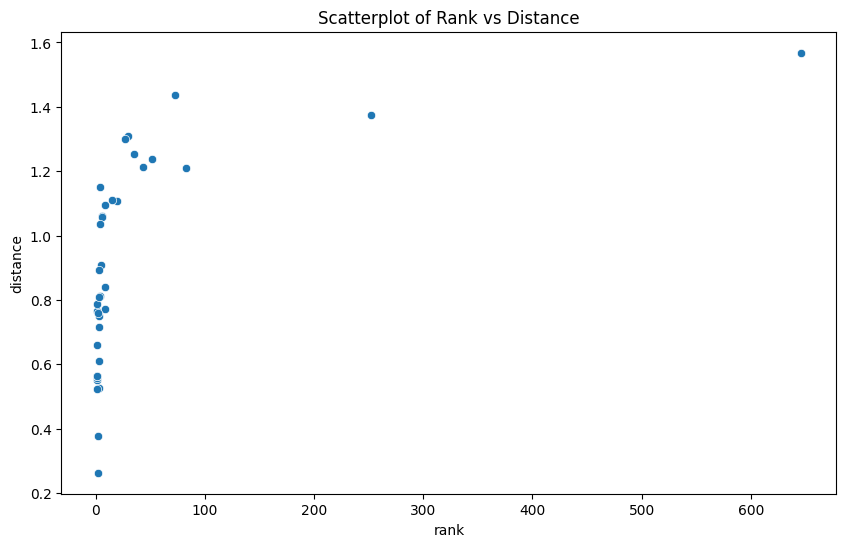

In [170]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rank', y='distance', data=ens_pairs)
plt.title('Scatterplot Rank vs Distance')
plt.show()

### Time of day

0x76232accd8b6e1827a00462abd9b3cffcad68b9e 15
0xaa68328e0dd8e7ecde1b6c7a01e552c5e33df563 8


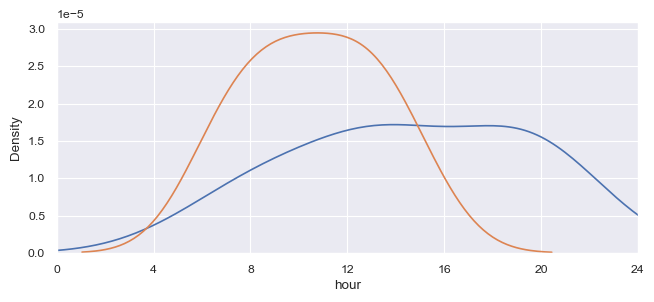

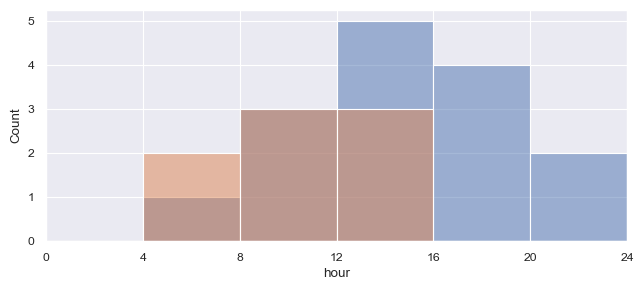

In [47]:
addresses = [idx_map[i] for i in [487, 493]]

show_patterns(all_transfers_df, addresses, hour_bins=6, show_kde=True)

### To do: Find a way to cluster the addresses

Do it with different tresholds, see how the number of clusters changes, visualize it

In [48]:
# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.8

# Iterate over all embeddings
for i in range(embeddings_d2v.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = index.get_dist_idx(i)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    if not neighbours:
        neighbours = set([i])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters
# 26,740

36185


[{47489, 50109},
 {0},
 {2},
 {16162, 36813},
 {4},
 {5},
 {6},
 {548, 551},
 {8},
 {9},
 {324, 327, 3100},
 {130, 134, 136},
 {12},
 {19405, 19516, 19517},
 {14, 137},
 {15},
 {136},
 {18095, 45561},
 {18, 19},
 {20},
 {21, 453},
 {402, 403},
 {23},
 {350, 37409, 37410},
 {25},
 {26},
 {27},
 {38030, 38212, 38214},
 {29},
 {30},
 {31},
 {24719, 24852},
 {39789, 39794, 39795},
 {34},
 {12427, 12429},
 {36},
 {37},
 {16132, 42059, 48975},
 {39},
 {39563, 39571},
 {13172, 13215},
 {9098, 12538, 51375},
 {30451, 46003},
 {136},
 {27531, 38933, 38935},
 {46},
 {122, 33810, 33813},
 {48},
 {49},
 {38515, 38520},
 {30927, 47946},
 {52},
 {53},
 {48240, 48644},
 {55},
 {56},
 {57},
 {9277, 9325},
 {59},
 {60},
 {8329, 33611, 33616},
 {62},
 {63},
 {43074, 43075},
 {50300, 50303, 50307},
 {37418, 37419},
 {67},
 {68},
 {13295, 38793, 45604, 47314},
 {70},
 {71},
 {3327, 30242},
 {31177, 41858, 49206},
 {74},
 {75},
 {191, 325, 47320, 48419, 50251},
 {77, 563},
 {1200, 44622, 44625},
 {79, 1180

In [75]:
transfers_grouped = all_transfers_df.groupby('hash').size().reset_index(name='tokensTransferred')
transfers_grouped = transfers_grouped.sort_values(by='tokensTransferred', ascending=False)
transfers_grouped


#merge with original dataframe
#evtl. native transfers weglassen weil meistens sowieso an andere addresse gesendet? wobei intra-set dem entgegenwirkt

if transfers_grouped['tokensTransferred'] >= 2:
    # check if user address present in 'from' AND 'to' column

# cluster all addresses that transferred someone an NFT for free -> likely a lot false-positives


,hash,tokensTransferred
0,0x00001c73c90deb59438591c4e66fea97d56a1965946d...,1
1,0x00003d696a133b465f4094382f21e7dc781df6dd719c...,1
2,0x000051fc3722cced4205cb14da47bcc3f47e6002894f...,1
3,0x000052c146c65b7085b55b0b79f6edd9da6d65e44a56...,1
4,0x00005eddb430bfb1bd61d00cdbd8b3dd88ed9bfb612c...,1
...,...,...
984111,0xffff80a8eee227ad9d19768ef234eccd7f8e860eb202...,1
984112,0xffff9b7f8935b72dcd0886dcc3ab0a63aacbaffea251...,1
984113,0xffff9e6c111ce30ebd2d3c8e556009b11805a5ac0068...,1
984114,0xffffa549db0b17a5169b0ff02b2a1dcf3db0a86333cb...,1


In [ ]:
from sklearn.cluster import DBSCAN

# Apply the DBSCAN algorithm
# You'll need to choose eps and min_samples based on your understanding of the data.
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples is the number of samples in a neighborhood for a point to be considered as a core point.
db = DBSCAN(eps=0.3, min_samples=10).fit(embeddings_d2v)

# Get cluster labels for each sample
labels = db.labels_